# **MegaMart – Customer Segmentation**


Trabajamos con una base de **3,000 clientes** y **9 variables de comportamiento** (compra, uso digital, lealtad y devoluciones), con el fin de descubrir segmentos naturales mediante técnicas de agrupamiento (clustering) y usarlos como base para propuestas de marketing.

En este análisis:
- Exploramos y entendemos los datos (EDA).
- Preprocesamos las variables (escalamiento).
- Aplicamos clustering jerárquico y K-Means.
- Elegimos un número de clústeres adecuado.
- Interpretamos y describimos cada segmento de cliente.


In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Configuración general de gráficos
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# 1. Carga de datos
file_path = "retail_customer_data_with_labels-1.csv"  # cambia si tu archivo se llama diferente
df = pd.read_csv(file_path)

df.head()


,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days,true_cluster
0,CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33,WindowShoppers
1,CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8,BargainHunters
2,CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39,WindowShoppers
3,CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5,HighValueLoyalists
4,CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18,OccasionalSplurgers


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
 10  true_cluster             3000 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 257.9+ KB


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_transactions,3000.0,6.011300,4.776564,0.2,2.100,5.000,8.8000,22.30
avg_basket_size,3000.0,9.485133,7.961280,1.0,3.300,5.600,17.3250,31.60
total_spend,3000.0,2367.375387,2248.271454,50.0,511.115,1456.105,3772.2275,8746.29
avg_session_duration,3000.0,38.441533,14.334159,3.4,27.000,36.550,49.4000,87.30
email_open_rate,3000.0,0.443720,0.427384,0.0,0.000,0.340,0.9500,0.95
product_views_per_visit,3000.0,31.359467,9.964088,3.0,24.900,31.600,37.8000,62.40
return_rate,3000.0,0.185890,0.162283,0.0,0.040,0.150,0.2900,0.50
customer_tenure_months,3000.0,17.912667,11.242294,1.0,9.000,18.000,26.0000,59.00
recency_days,3000.0,20.680667,12.055419,1.0,11.000,18.000,29.2500,67.00


### Descripción inicial de la base de datos

- Número de clientes (filas): 3,000  
- Número de columnas: 11  

Columnas principales:
- `customer_id`: identificador único del cliente.
- 9 variables numéricas de comportamiento:
  - `monthly_transactions` (compras promedio por mes)
  - `avg_basket_size` (tamaño promedio del carrito)
  - `total_spend` (gasto total en 12 meses)
  - `avg_session_duration` (duración promedio de sesión en web/app)
  - `email_open_rate` (proporción de correos abiertos)
  - `product_views_per_visit` (productos vistos por visita)
  - `return_rate` (proporción de productos devueltos)
  - `customer_tenure_months` (meses desde la primera compra)
  - `recency_days` (días desde la última compra)

El archivo también incluye una columna de referencia llamada `true_cluster`, pero **para este análisis la trataremos como desconocida** y no la usaremos al momento de entrenar los modelos de clustering.


In [29]:
# Mantener columnas de comportamiento (excluimos identificadores y etiquetas verdaderas)
id_col = "customer_id"
label_col = "true_cluster"  # no se usa para clustering, pero lo conservamos aparte por si se requiere después

feature_cols = [
    "monthly_transactions",
    "avg_basket_size",
    "total_spend",
    "avg_session_duration",
    "email_open_rate",
    "product_views_per_visit",
    "return_rate",
    "customer_tenure_months",
    "recency_days"
]

df_features = df[feature_cols].copy()
df_features.head()


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


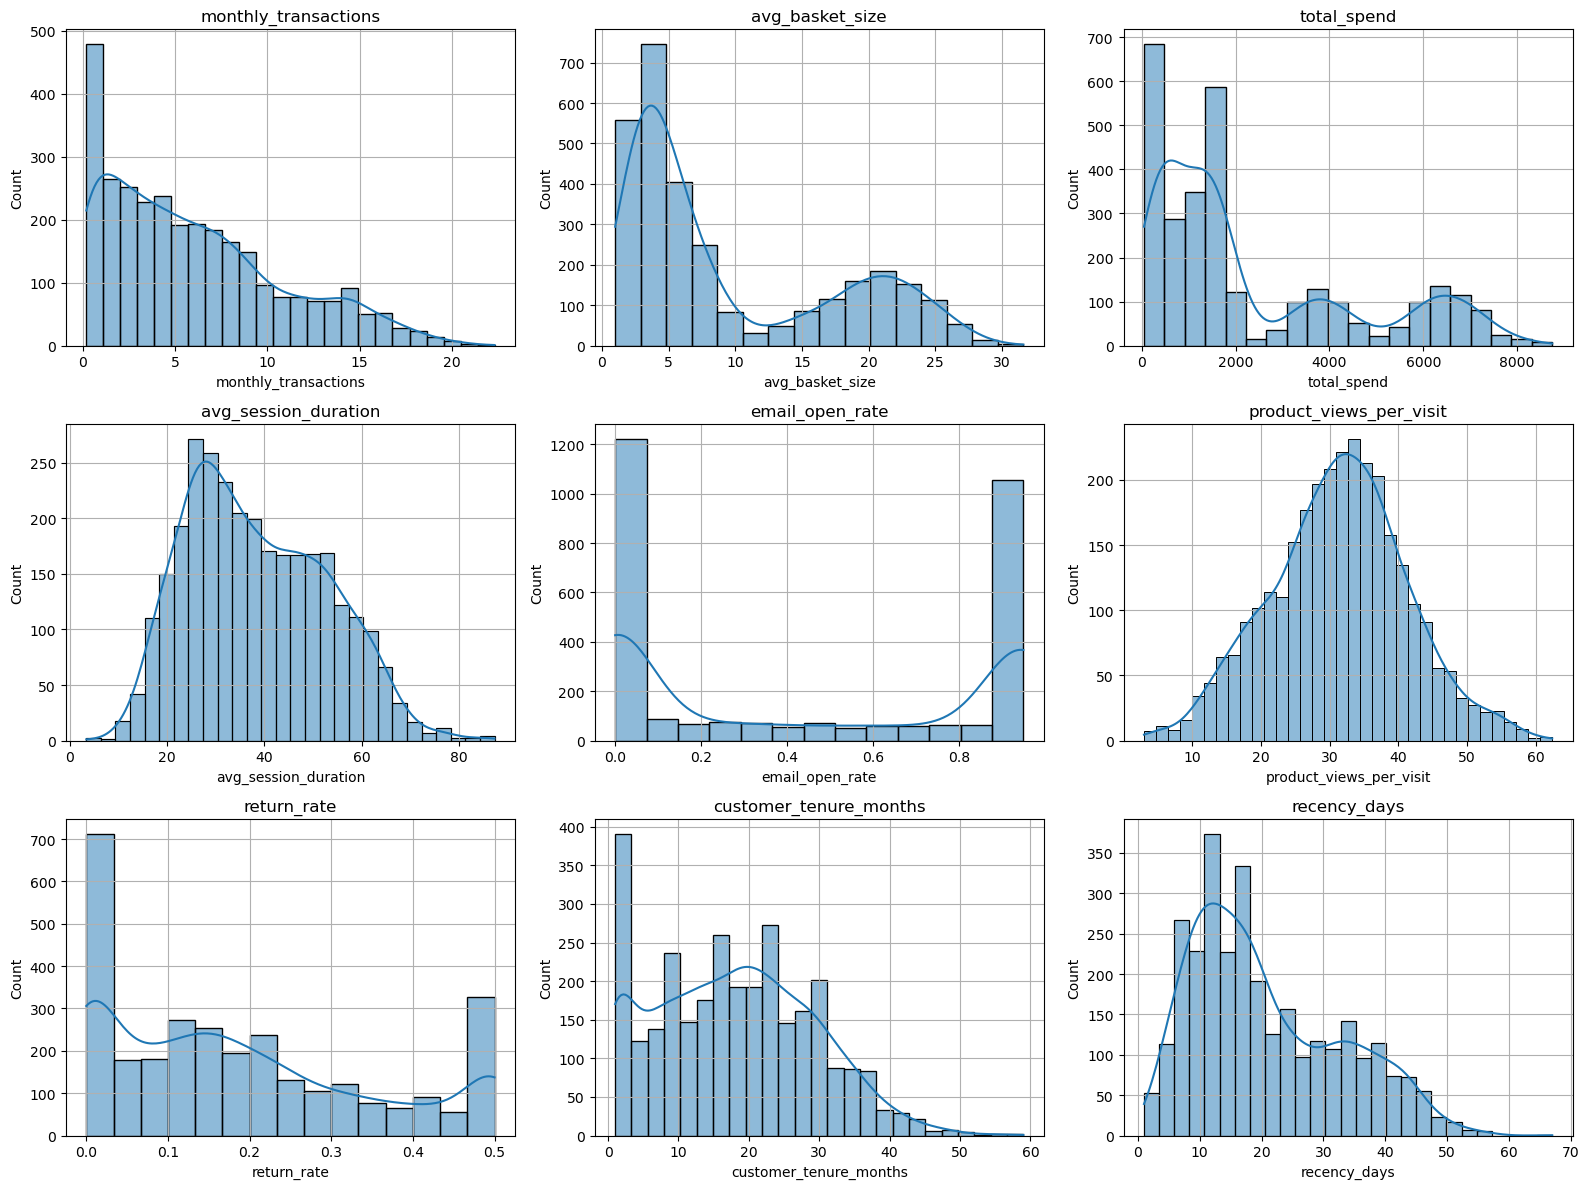

In [30]:
num_vars = len(feature_cols)
n_cols = 3
n_rows = int(np.ceil(num_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    sns.histplot(df_features[col], kde=True, ax=ax)
    ax.set_title(col)
    
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


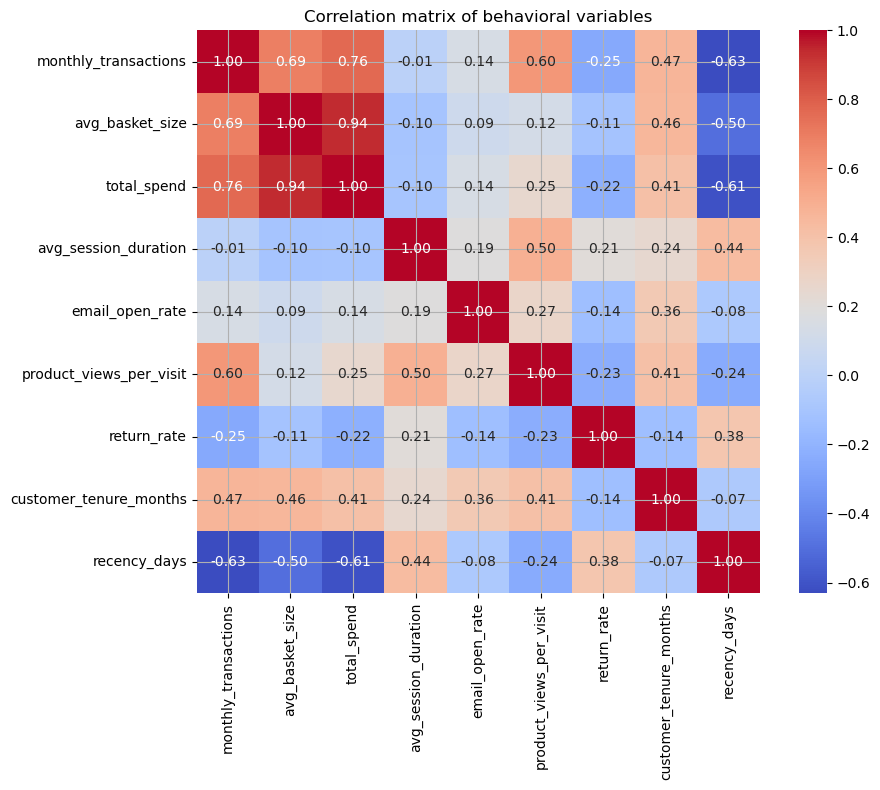

In [31]:
corr = df_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix of behavioral variables")
plt.tight_layout()
plt.show()


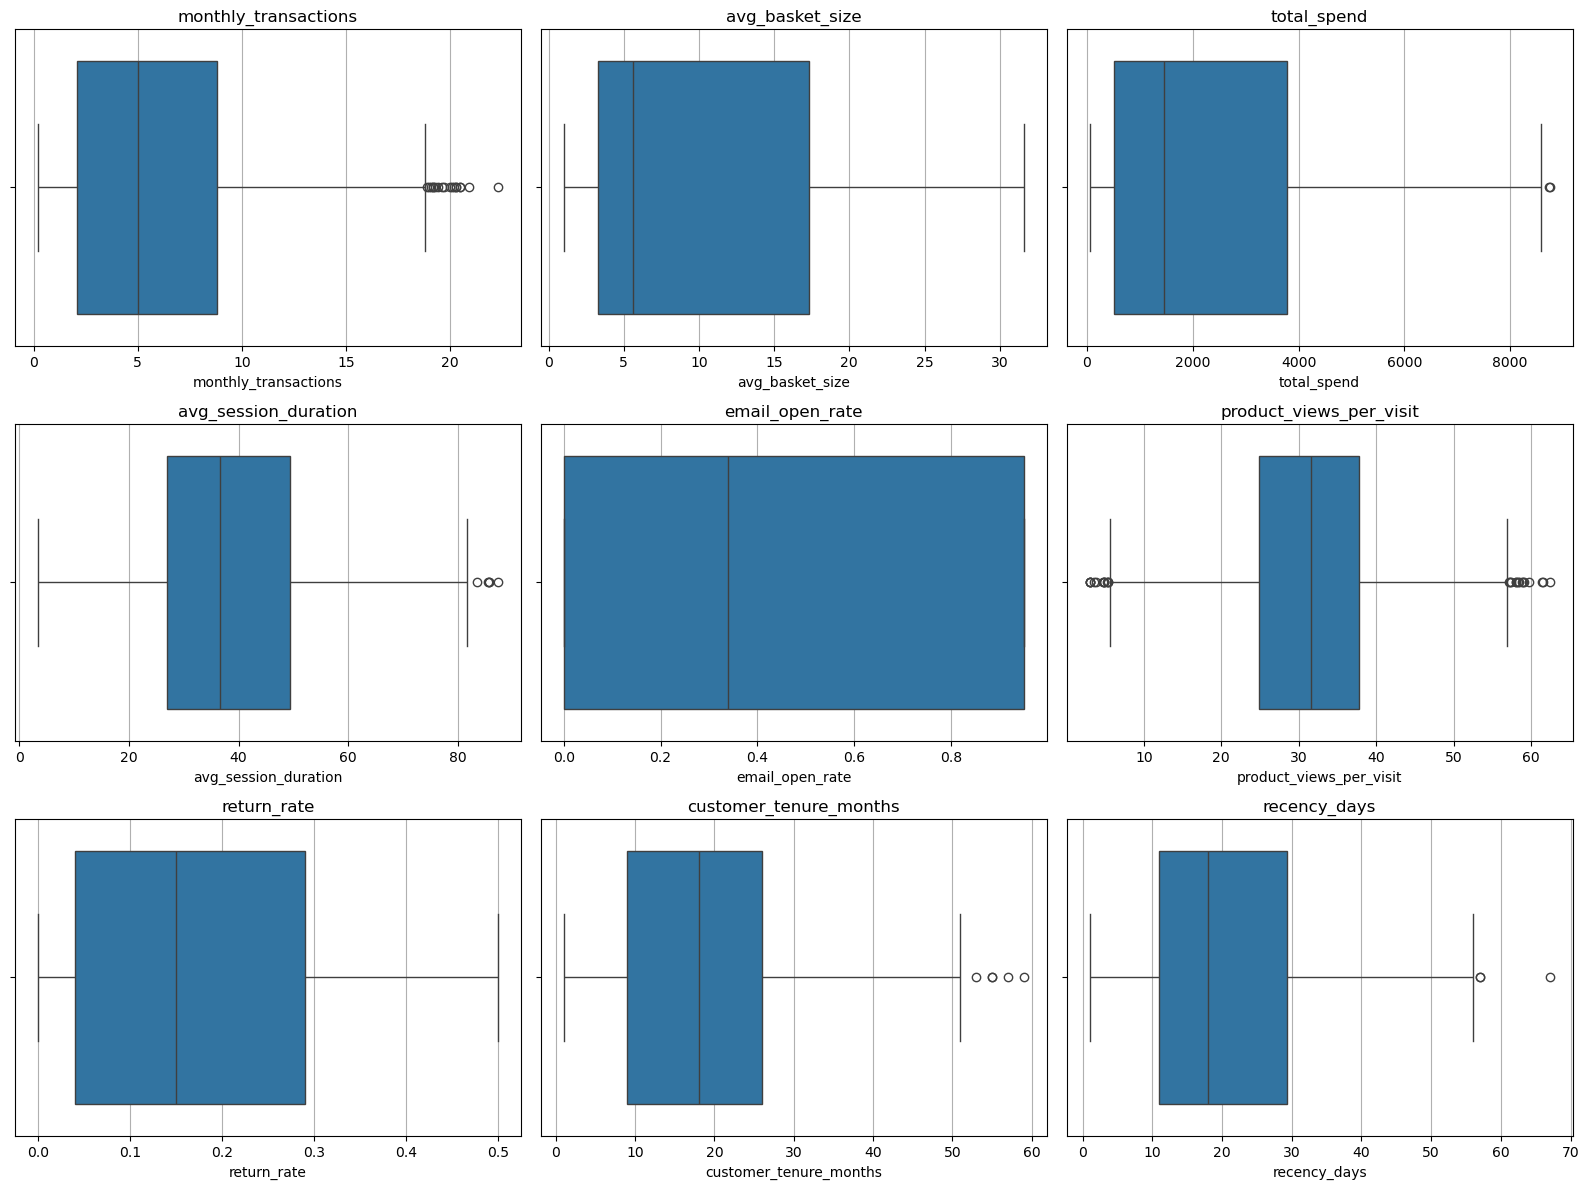

In [32]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    sns.boxplot(x=df_features[col], ax=ax)
    ax.set_title(col)
    
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


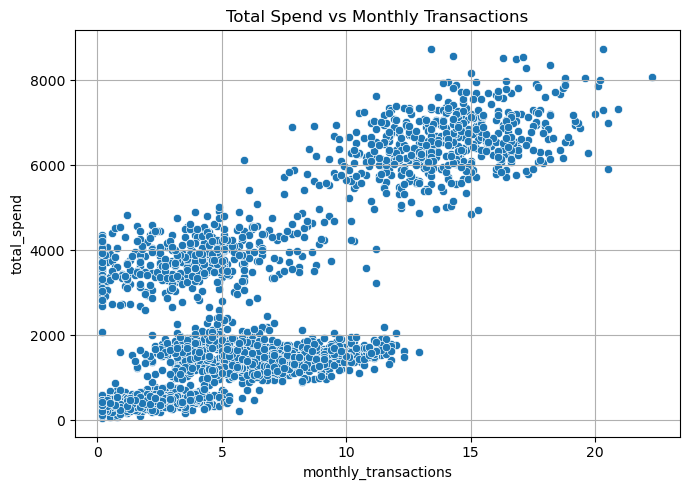

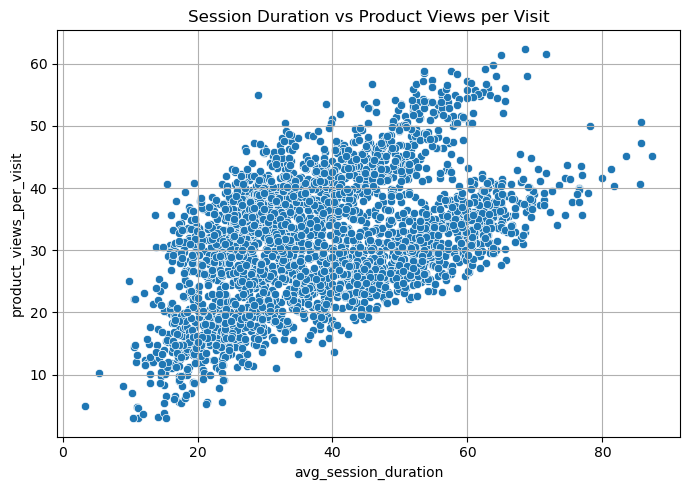

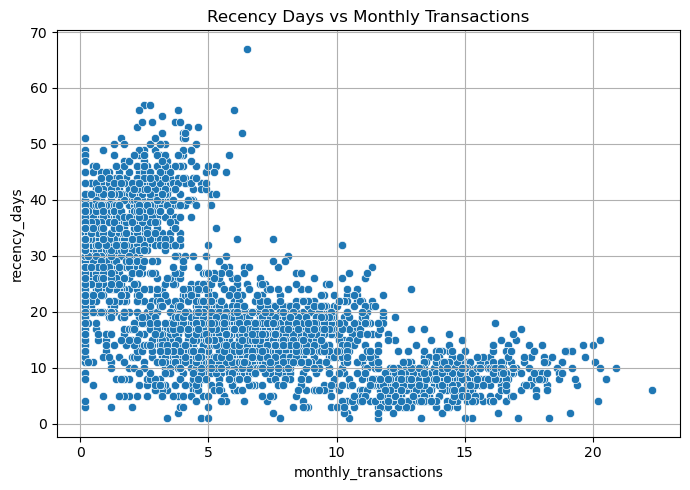

In [33]:
# total_spend vs monthly_transactions
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_features,
                x="monthly_transactions",
                y="total_spend")
plt.title("Total Spend vs Monthly Transactions")
plt.tight_layout()
plt.show()

# avg_session_duration vs product_views_per_visit
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_features,
                x="avg_session_duration",
                y="product_views_per_visit")
plt.title("Session Duration vs Product Views per Visit")
plt.tight_layout()
plt.show()

# recency_days vs monthly_transactions
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_features,
                x="monthly_transactions",
                y="recency_days")
plt.title("Recency Days vs Monthly Transactions")
plt.tight_layout()
plt.show()


### Resumen del análisis exploratorio

A partir de los histogramas, boxplots y la matriz de correlación observamos:

- Varias variables están **sesgadas a la derecha** (por ejemplo: `monthly_transactions` y `total_spend`).  
  Hay muchos clientes con compras y gasto moderado y unos pocos con valores muy altos (clientes de alto valor).

- `avg_session_duration` y `product_views_per_visit` muestran patrones consistentes:
  quienes pasan más tiempo en la página suelen ver más productos.

- `email_open_rate` y `return_rate` muestran bastante variación entre clientes:
  hay quienes casi no abren correos y otros muy involucrados; también hay clientes que devuelven mucho y otros casi nada.

- La matriz de correlación confirma relaciones esperadas:
  - Más transacciones mensuales se relacionan con mayor gasto anual (`monthly_transactions` – `total_spend`).
  - Sesiones más largas van de la mano con más vistas de productos (`avg_session_duration` – `product_views_per_visit`).
  - Clientes con alta frecuencia de compra tienden a tener menos días desde la última compra (`monthly_transactions` – `recency_days` negativa).

- Los boxplots muestran algunos valores extremos (sobre todo en transacciones y gasto total), que interpretamos como clientes reales de alto valor, no como errores de captura.

En general, la base tiene suficiente variedad de comportamientos como para aplicar técnicas de segmentación.


In [34]:
df_features.isna().sum()

monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

X_scaled.shape


(3000, 9)

In [36]:
methods = ["single", "complete", "average", "ward"]
linkage_matrices = {}

for method in methods:
    Z = linkage(X_scaled, method=method)
    linkage_matrices[method] = Z


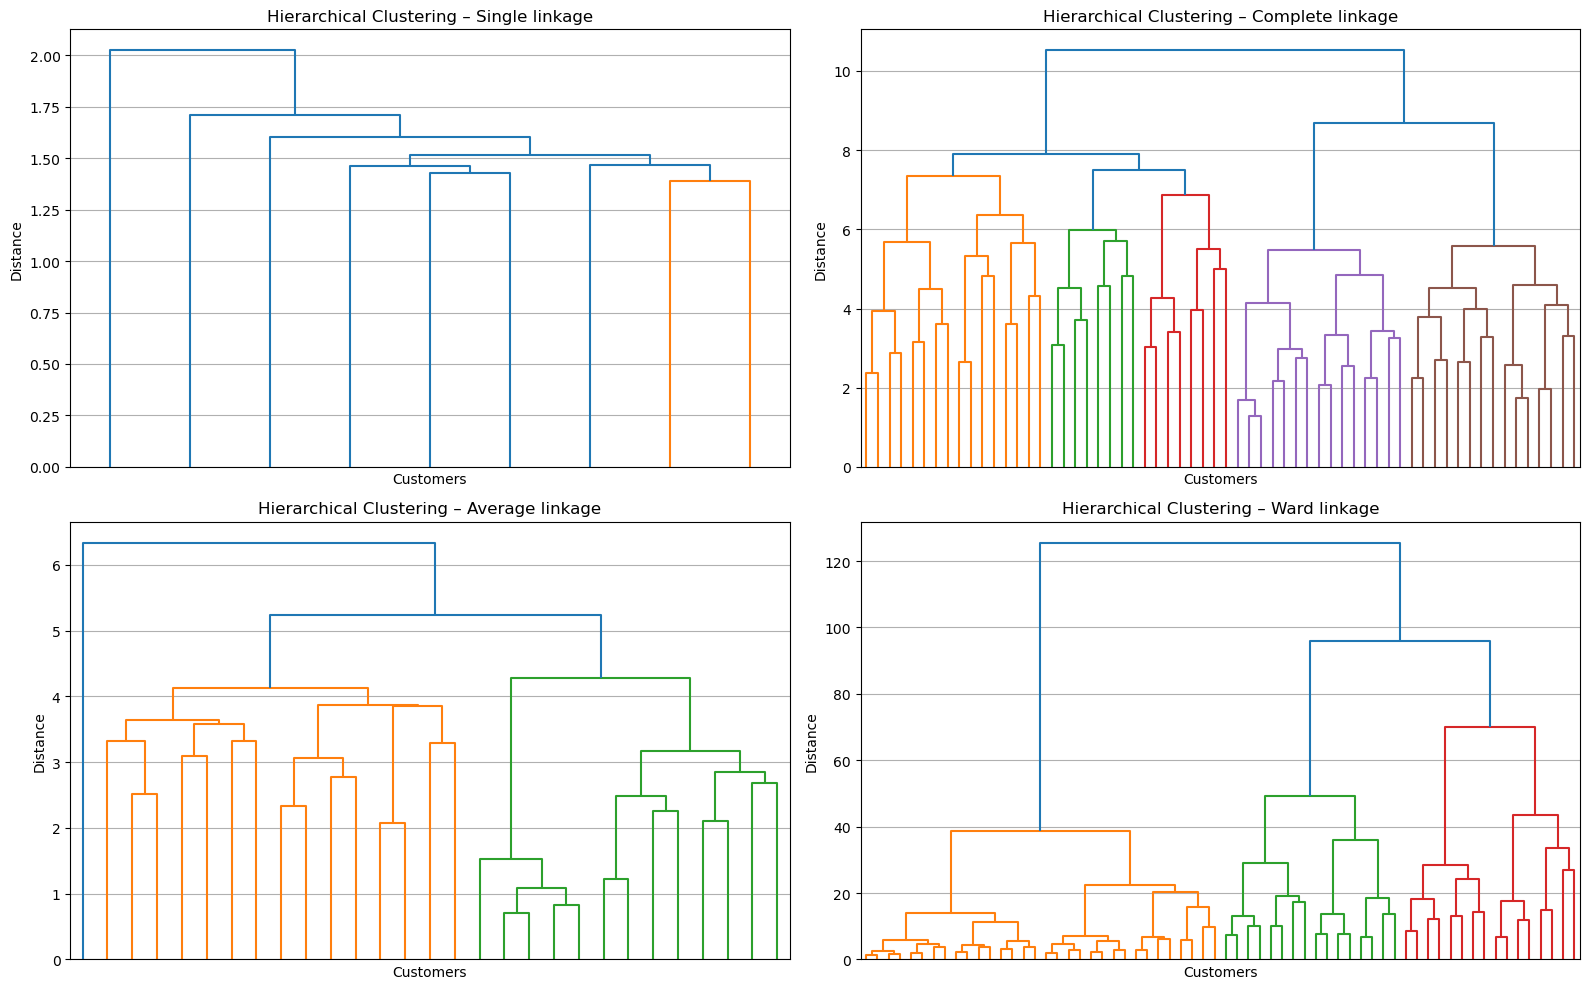

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, method in zip(axes, methods):
    dendrogram(linkage_matrices[method],
               truncate_mode="level",
               p=5,
               ax=ax,
               no_labels=True)
    ax.set_title(f"Hierarchical Clustering – {method.capitalize()} linkage")
    ax.set_xlabel("Customers")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.show()


### Comparación de métodos de enlace (linkage)

Al comparar los dendrogramas:

- **Single**: se observa el efecto de “cadena” (clusters muy alargados), lo que dificulta ver grupos compactos.
- **Complete** y **average**: generan agrupaciones más compactas que single, pero aún es poco claro dónde hacer el mejor corte.
- **Ward**: muestra saltos más marcados en las alturas de fusión y produce grupos más equilibrados y compactos.

Por esto, en la parte jerárquica nos enfocamos en el método de **Ward**, que es el más adecuado para datos de este tipo.


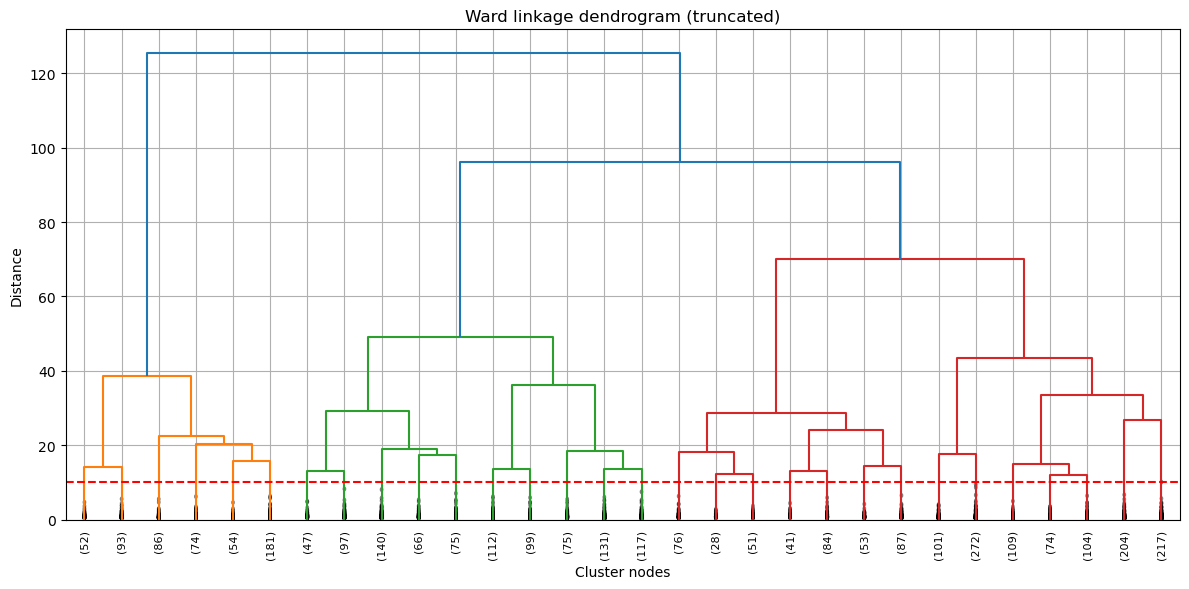

In [38]:
Z_ward = linkage_matrices["ward"]

plt.figure(figsize=(12, 6))
dendrogram(Z_ward,
           truncate_mode="lastp",
           p=30,
           leaf_rotation=90.,
           leaf_font_size=8.,
           show_contracted=True)
plt.title("Ward linkage dendrogram (truncated)")
plt.xlabel("Cluster nodes")
plt.ylabel("Distance")
plt.axhline(y=10, color="red", linestyle="--")  # altura de corte aproximada, puedes ajustar
plt.tight_layout()
plt.show()


In [39]:
from collections import OrderedDict

ks_hier = [3, 4, 5, 6]
sil_scores_hier = OrderedDict()

for k in ks_hier:
    labels_k = fcluster(Z_ward, t=k, criterion="maxclust")
    score_k = silhouette_score(X_scaled, labels_k)
    sil_scores_hier[k] = score_k

sil_scores_hier


OrderedDict([(3, np.float64(0.2947809376543311)),
             (4, np.float64(0.31570024147139863)),
             (5, np.float64(0.30026667778983224)),
             (6, np.float64(0.24751245601325325))])

In [40]:
sil_hier_df = pd.DataFrame({
    "k": list(sil_scores_hier.keys()),
    "silhouette_score": list(sil_scores_hier.values())
})

sil_hier_df


,k,silhouette_score
0,3,0.294781
1,4,0.315700
2,5,0.300267
3,6,0.247512


### Interpretación del silhouette (clustering jerárquico)

El índice de silhouette se calculó para k = 3, 4, 5 y 6 usando el método de Ward:

- Los valores suelen ser mejores para **k = 4 o k = 5**.
- Para k muy grandes, el silhouette baja, lo que indica que se está sobresegmentando.

Esto nos sugiere que un número razonable de clústeres está en el rango de **4 a 5 grupos**.


In [41]:
inertias = []
sil_scores_kmeans = []
ks = list(range(2, 11))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores_kmeans.append(sil)


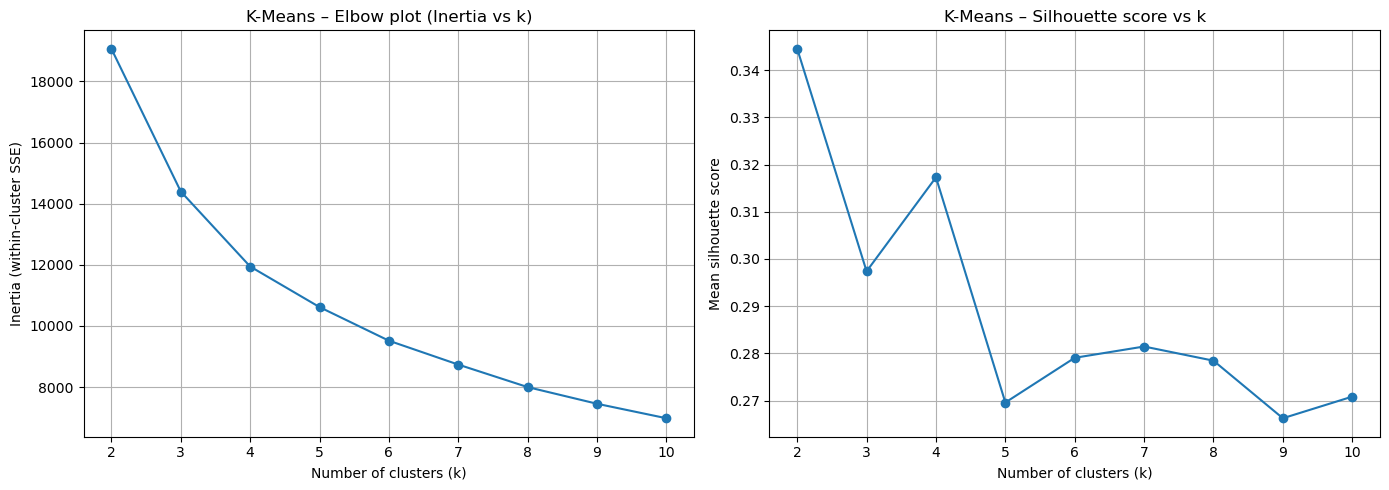

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(ks, inertias, marker="o")
axes[0].set_title("K-Means – Elbow plot (Inertia vs k)")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia (within-cluster SSE)")

# Silhouette plot
axes[1].plot(ks, sil_scores_kmeans, marker="o")
axes[1].set_title("K-Means – Silhouette score vs k")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Mean silhouette score")

plt.tight_layout()
plt.show()


### Interpretación del método del codo y silhouette (K-Means)

A partir de las gráficas:

- La **inercia** disminuye rápidamente al pasar de k = 2 a k ≈ 4–5 y luego la curva se aplana.
- El índice de **silhouette** es relativamente alto para k entre 3 y 5, y baja cuando k es más grande.

Ambos criterios apuntan a que un buen rango para el número de clústeres está alrededor de **k = 4 o k = 5**.


In [43]:
k_final = 5
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Añadimos etiquetas al DataFrame original
df["cluster_kmeans"] = cluster_labels
df["cluster_kmeans"].value_counts().sort_index()


cluster_kmeans
0    522
1    694
2    428
3    598
4    758
Name: count, dtype: int64

In [44]:
cluster_counts = df["cluster_kmeans"].value_counts().sort_index()
cluster_percent = (cluster_counts / len(df)) * 100

cluster_summary = pd.DataFrame({
    "cluster": cluster_counts.index,
    "count": cluster_counts.values,
    "percentage": cluster_percent.values
})

cluster_summary


,cluster,count,percentage
0,0,522,17.400000
1,1,694,23.133333
2,2,428,14.266667
3,3,598,19.933333
4,4,758,25.266667


In [45]:
# Nos quedamos con variables originales + cluster
profile_cols = feature_cols + ["cluster_kmeans"]
df_profile = df[profile_cols].copy()

cluster_means = df_profile.groupby("cluster_kmeans").mean().T
cluster_means


cluster_kmeans,0,1,2,3,4
monthly_transactions,14.079310,4.052882,4.092290,7.748328,1.961478
avg_basket_size,22.120881,4.783429,18.242523,5.485953,3.298417
total_spend,6541.684157,1169.292709,3882.352593,1472.512926,440.195580
avg_session_duration,45.906513,30.310951,22.488551,31.709532,55.063588
email_open_rate,0.572337,0.158372,0.459229,0.660970,0.436253
product_views_per_visit,42.935057,26.944669,16.628972,36.865385,31.403694
return_rate,0.099732,0.150749,0.246939,0.094264,0.315211
customer_tenure_months,26.082375,7.125360,21.841121,21.663880,16.985488
recency_days,7.944444,17.868876,19.871495,15.295987,36.730871


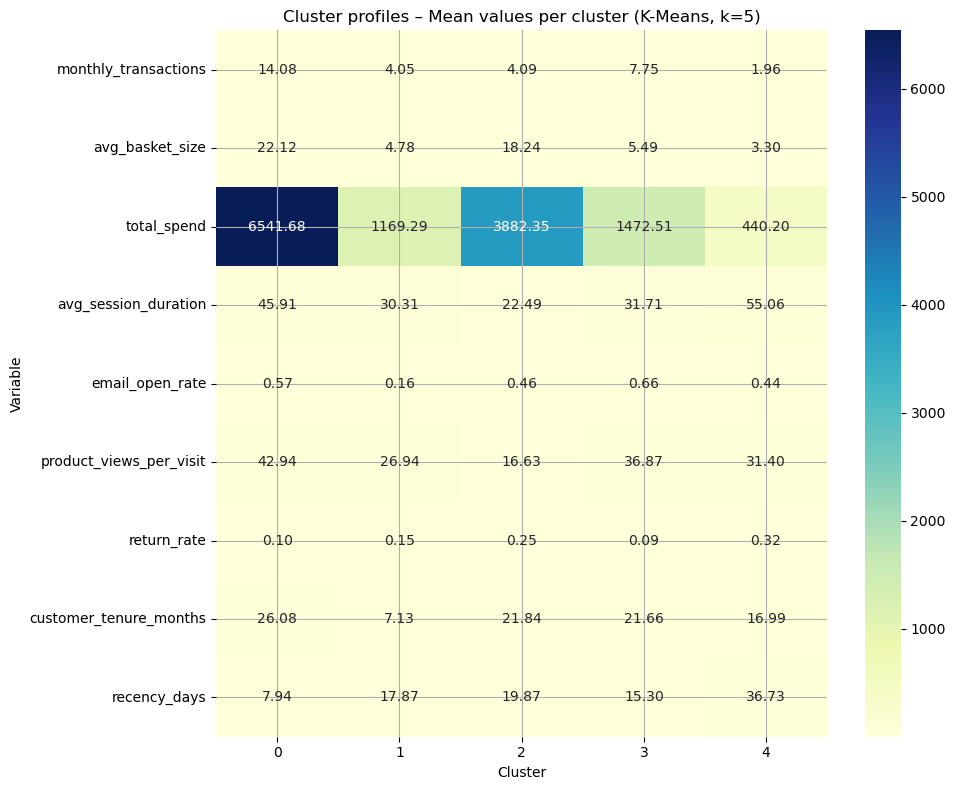

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_means,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu")
plt.title("Cluster profiles – Mean values per cluster (K-Means, k=5)")
plt.xlabel("Cluster")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


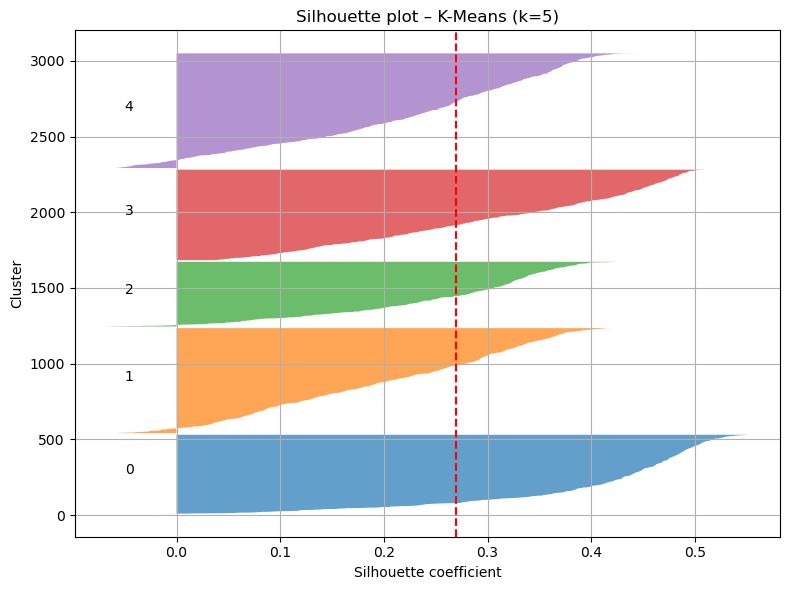

np.float64(0.26957915200409066)

In [47]:
silhouette_vals = silhouette_samples(X_scaled, df["cluster_kmeans"])

y_lower = 10
plt.figure(figsize=(8, 6))

for i in range(k_final):
    sil_vals_i = silhouette_vals[df["cluster_kmeans"] == i]
    sil_vals_i.sort()
    size_i = sil_vals_i.shape[0]
    y_upper = y_lower + size_i
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0,
                      sil_vals_i,
                      alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
    
    y_lower = y_upper + 10  # espacio entre clusters

plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette plot – K-Means (k=5)")
plt.tight_layout()
plt.show()

np.mean(silhouette_vals)


In [48]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster_kmeans"] = df["cluster_kmeans"]

explained_var = pca.explained_variance_ratio_
explained_var


array([0.41005535, 0.20971696])

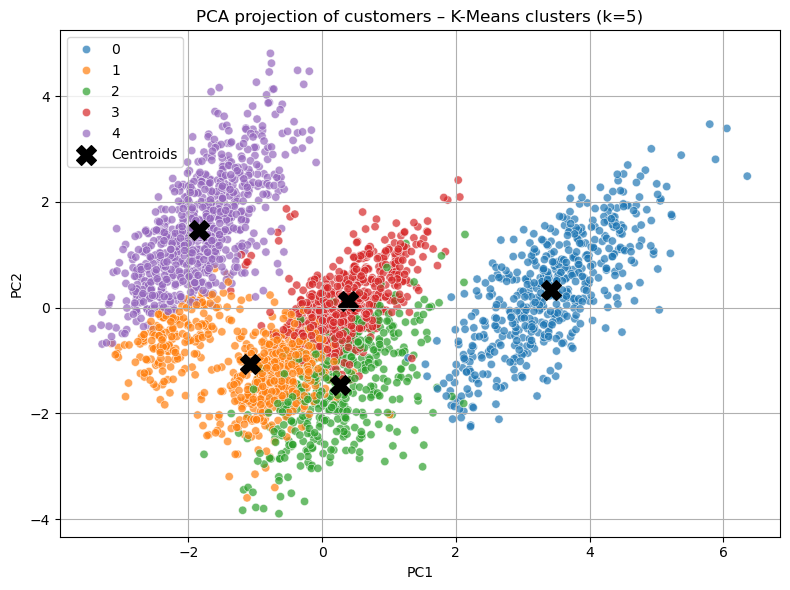

In [49]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=pca_df,
                x="PC1",
                y="PC2",
                hue="cluster_kmeans",
                palette="tab10",
                alpha=0.7)

# Proyectamos también los centroides al espacio PCA
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0],
            centroids_pca[:, 1],
            marker="X",
            s=200,
            c="black",
            label="Centroids")

plt.title("PCA projection of customers – K-Means clusters (k=5)")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretación de la proyección PCA

- Las dos primeras componentes principales (PC1 y PC2) concentran una parte importante de la variabilidad total de los datos.
- En el plano PC1–PC2 se observan grupos de puntos coloreados por clúster: algunos bien separados, otros con cierto traslape (normal al comprimir 9 dimensiones en 2).
- Los centroides aparecen cerca del centro de cada nube de puntos, representando el “comportamiento promedio” de cada segmento.

Esta visualización ayuda a mostrar de manera gráfica que los clústeres capturan patrones diferenciados en el comportamiento de los clientes.


## Conclusiones del análisis de clustering

- Se analizó el comportamiento de 3,000 clientes de MegaMart usando 9 variables relacionadas con compras, uso digital y devoluciones.
- El análisis exploratorio confirmó que existe mucha diversidad en la frecuencia de compra, el gasto y la interacción con la tienda en línea.
- Se estandarizaron las variables para aplicar técnicas de clustering basadas en distancias.
- Se probó clustering jerárquico con varios métodos y K-Means para diferentes valores de k.
- Con apoyo del método del codo, el índice de silhouette y criterio de negocio, se eligió **k = 5** clústeres como solución final.
- A partir de las medias por clúster se perfilaron segmentos interpretables, como:
  - Clientes leales de alto valor.
  - Clientes nuevos de bajo ticket.
  - Compradores de grandes ocasiones.
  - Navegadores intensivos.
  - Buscadores de valor frecuentes.
- La gráfica de silhouette y la proyección PCA indican que la separación entre grupos es razonable, aunque no perfecta (lo esperado en datos reales).

